# Imports

In [1]:
import nevergrad as ng
import tensorflow as tf
import numpy as np
import random
import math
import pickle
import Simulation.KNNSim as sim
startIndexes = pickle.load(open('Simulation/E0F1_index_transmision.pkl', 'rb'))
usablePVindextable = pickle.load(open('Simulation/E0F1_index_I1.pkl', 'rb'))
pvNames = pickle.load(open('Simulation/E0F1Names.pkl', 'rb'))


knn-Sim: Data loaded from Simulation/E0F1.pkl
knn-Sim: Index filled
knn-Sim: Index build
knn-Sim: READY


# Helper Tabels and Functions

In [291]:
def modelOutToPosition(modelOut, allowedPVs, oldPosition):
    for i, change in enumerate(modelOut):
        if allowedPVs[i]:
            oldPosition[usablePVindextable[i]] += change
        modelOut[i] = oldPosition[usablePVindextable[i]]
    return [oldPosition, modelOut]

def updatePosition(newValues, allowedPVs, oldPosition):
    
    for i, change in enumerate(newValues):
        if allowedPVs[i]:
            oldPosition[usablePVindextable[i]] = change
        newValues[i] = oldPosition[usablePVindextable[i]]
    return [oldPosition, newValues]

optimum = list(sim.states[40104][0])
baseOptimum = []

for i in usablePVindextable:
    baseOptimum.append(optimum[i])

var_I1 = [0.4656249999999993,0.17000000000000035,0.6524999999999999,0.14566250000000042,0.34001250000000066,0.19999999999999996,0.14499999999999957,0.13628749999999912,2.239959716796875,1.40057373046875,2.3402099609375,1.9005126953125]

def getStartingPossition():
    optimum = list(sim.states[40104][0])
    sectionPos = []
    for i, variance in enumerate(var_I1):
        newValue = baseOptimum[i] + (random.random()-0.5) * variance
        optimum[usablePVindextable[i]] = newValue
        sectionPos.append(newValue)
    return [np.array(optimum), np.array(sectionPos)]

def convertForOpimizer(sectionPos):
    return optimizer.parametrization.spawn_child(new_value = sectionPos)



In [321]:
def replaceValueForDim(replacement , base_vector, dim):
    r = base_vector.copy()
    r[dim] = replacement
    return r

In [292]:
def performOtimization(optimizer, printouts = False, zeroStart = True, allowedPVs = np.ones(12)):
    
    loss = 0
    while loss == 0:
        globalPos, sectionPos = getStartingPossition()
        loss = sim.get(globalPos)
        if zeroStart:
            break
    bestValue = loss
        
    pathX = [sectionPos]
    pathY = [loss]
    minPathY=[loss]
    
    if printouts: 
        print(f'Starting Possition {loss: .2f}')
        
    x = convertForOpimizer(sectionPos)
    optimizer.tell(x, sim.get(globalPos))
    
    for _ in range(optimizer.budget):
        
        x = optimizer.ask()
        
        globalPos, sectionPos = updatePosition(x.args[0], allowedPVs, globalPos)
        pathX.append(sectionPos)
        
        loss = sim.get(globalPos)
        optimizer.tell(x, loss)
        pathY.append(loss)
        
        if loss < bestValue:
            bestValue = loss
        minPathY.append(bestValue)
    if printouts: 
        print(f'End Possition {loss: .2f} with best Value seen at {bestValue: .2f}')
    return [pathX, pathY, minPathY]

In [284]:
def performRandomSerach(numSteps, zeroStart = True):
    pathX = []
    pathY = []
    minPathY=[]
    bestValue = 0
    for i in range(numSteps):
        globalPos, sectionPos = getStartingPossition()
        pathX.append(sectionPos)
        loss = sim.get(globalPos)
        pathY.append(loss)
        if loss < bestValue:
            bestValue = loss
        minPathY.append(bestValue)
    return [pathX, pathY, minPathY]

In [314]:
def performOtimizationModel(model, numSteps, printouts = False, zeroStart = True, allowedPVs = np.ones(12)):
    loss = 0
    while loss == 0 :
        globalPos, sectionPos = getStartingPossition()
        loss = sim.get(globalPos)
        if zeroStart:
            break
    
    pathX = [sectionPos]
    pathY = [loss]
    minPathY=[loss]
    
    bestValue = loss
        
    if printouts: 
        print(f'Starting Possition {loss: .2f}')
   
    model.layers[0].reset_states()
    model.layers[1].reset_states() 
    model.layers[2].reset_states()
    for _ in range(numSteps):
        
        modelIn = np.reshape(np.concatenate((allowedPVs, sectionPos, [loss]), axis=0), (1, 1, len(sectionPos)*2+1))
        x = model(modelIn)
        
        globalPos, sectionPos = modelOutToPosition(x.numpy()[0], allowedPVs, globalPos)
        pathX.append(sectionPos)
        
        loss = sim.get(globalPos)
        pathY.append(loss)
        
        if loss < bestValue:
            bestValue = loss
        minPathY.append(bestValue)
    
    if printouts: 
        print(f'End Possition {loss: .2f} with best Value seen at {bestValue: .2f}')
    return [pathX, pathY, minPathY]

In [ ]:
def performOtimizationModelPlus(model, numSteps, printouts = False, zeroStart = True, allowedPVs = np.ones(12)):
    loss = 0
    while loss == 0 :
        globalPos, sectionPos = getStartingPossition()
        loss = sim.get(globalPos)
        if zeroStart:
            break

    optimizer = ng.optimizers.NGOpt(parametrization=12, budget= numSteps-10, num_workers=1)
    x = convertForOpimizer(sectionPos)
    optimizer.tell(x, sim.get(globalPos))

    pathX = [sectionPos]
    pathY = [loss]
    minPathY=[loss]

    bestValue = loss

    model.layers[0].reset_states()
    model.layers[1].reset_states() 
    model.layers[2].reset_states()
    for _ in range(10):
        modelIn = np.reshape(np.concatenate((allowedPVs, sectionPos, [loss]), axis=0), (1, 1, len(sectionPos)*2+1))
        x = model(modelIn)

        globalPos, sectionPos = modelOutToPosition(x.numpy()[0], allowedPVs, globalPos)
        pathX.append(sectionPos)

        loss = sim.get(globalPos)
        pathY.append(loss)

        x = convertForOpimizer(sectionPos)
        optimizer.tell(x, sim.get(globalPos))

        if loss < bestValue:
            bestValue = loss
        minPathY.append(bestValue)

    
    
    for _ in range(optimizer.budget):
        
        x = optimizer.ask()
        
        globalPos, sectionPos = updatePosition(x.args[0], allowedPVs, globalPos)
        pathX.append(sectionPos)
        
        loss = sim.get(globalPos)
        optimizer.tell(x, loss)
        pathY.append(loss)
        
        if loss < bestValue:
            bestValue = loss
        minPathY.append(bestValue)
    
    return [pathX, pathY, minPathY]

# Import Model

In [260]:
loaded_model = tf.keras.models.load_model('ModelI1SC02.keras')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, None, 32)             7424      
                                                                 
 lstm_1 (LSTM)               (1, None, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (1, 32)                   8320      
                                                                 
 dense (Dense)               (1, 64)                   2112      
                                                                 
 dense_1 (Dense)             (1, 32)                   2080      
                                                                 
 dense_2 (Dense)             (1, 32)                   1056      
                                                                 
 dense_3 (Dense)             (1, 16)                   5

# Averaged Performance

In [286]:
allowedPVs = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [317]:
pathsModel=[]
for i in range(100):
    _, _,pathY = performOtimizationModel(loaded_model, 50, zeroStart = True, allowedPVs = allowedPVs)
    pathsModel.append(pathY)

In [318]:
pathsNGOpt=[]
for i in range(100):
    optimizer = ng.optimizers.NGOpt(parametrization=12, budget=50, num_workers=1)
    _, _,pathY = performOtimization(optimizer, zeroStart = True, allowedPVs = allowedPVs)
    pathsNGOpt.append(pathY)


In [319]:
pathsOnePlusOne=[]
for i in range(100):
    optimizer = ng.optimizers.OnePlusOne(parametrization=12, budget=50, num_workers=1)
    _, _,pathY = performOtimization(optimizer, zeroStart = True, allowedPVs = allowedPVs)
    pathsOnePlusOne.append(pathY)

### Plotting our Data

In [108]:
import matplotlib.pyplot as plt

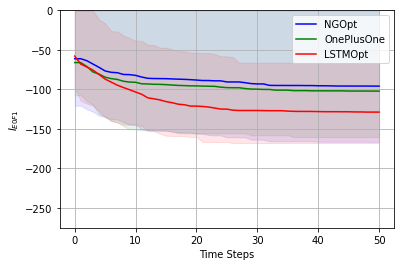

In [320]:
path_length = 51

paths1 = pathsNGOpt
paths2 = pathsOnePlusOne
paths3 = pathsRND
paths4 = pathsModel

# Calculate statistics
mean_path1 = np.mean(paths1, axis=0)
lower_percentile1 = np.percentile(paths1, 25, axis=0)
upper_percentile1 = np.percentile(paths1, 75, axis=0)

mean_path2 = np.mean(paths2, axis=0)
lower_percentile2 = np.percentile(paths2, 25, axis=0)
upper_percentile2 = np.percentile(paths2, 75, axis=0)

mean_path3 = np.mean(paths3, axis=0)
lower_percentile3 = np.percentile(paths3, 25, axis=0)
upper_percentile3 = np.percentile(paths3, 75, axis=0)

mean_path4 = np.mean(paths4, axis=0)
lower_percentile4 = np.percentile(paths4, 25, axis=0)
upper_percentile4 = np.percentile(paths4, 75, axis=0)


# Plot the mean path for each subplot
plt.plot(mean_path1, label='NGOpt', color='blue')
plt.plot(mean_path2, label='OnePlusOne', color='green')
#plt.plot(mean_path3, label='RandomSearch', color='yellow')
plt.plot(mean_path4, label='LSTMOpt', color='red')

# Plot the lower and upper percentiles as a shaded region for each subplot
plt.fill_between(range(path_length), lower_percentile1, upper_percentile1, color='blue', alpha=0.1)
plt.fill_between(range(path_length), lower_percentile2, upper_percentile2, color='green', alpha=0.1)
plt.fill_between(range(path_length), lower_percentile4, upper_percentile4, color='red', alpha=0.1)

plt.xlabel('Time Steps')
plt.ylabel(r'$I_{E0F1}$')
# Add legends
plt.legend()

plt.grid(True)
plt.ylim((-275,0))
plt.savefig("AVGI1SC02IvsSteps", dpi=300, bbox_inches='tight')
plt.show()

# Run on graph I1SC02

#### Generate Starting Topology

In [392]:
allowedPVs = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

loss = 0
while loss > -150 :
    globalPos, sectionPos = getStartingPossition()
    loss = sim.get(globalPos)
loss

-208.7559649631697

#### Choose Starting Position

In [517]:
setpoint = 98.93459473132453
globalPos[usablePVindextable[11]] = setpoint
sectionPos[11] = setpoint
loss = sim.get(globalPos)
pathX = [setpoint]
pathY = [loss]
minPathY = [loss]
loss

-21.842040734059573

#### The Graph optimization takes place on:

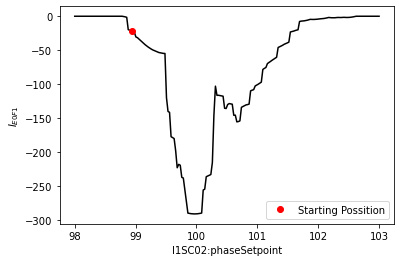

In [552]:
x_values = np.linspace(98, 103, 200)
base = globalPos
x_vectors = []
for value in x_values:
    x_vectors.append(replaceValueForDim(value , base, usablePVindextable[11]))
    
y_values = []
for vec in x_vectors:
    y_values.append(sim.get(vec))
    
plt.plot(x_values, y_values, color='black', alpha= 1)
plt.plot(setpoint, loss, 'ro', label='Starting Possition')
plt.xlabel('I1SC02:phaseSetpoint')
plt.ylabel(r'$I_{E0F1}$')
plt.legend()

plt.show()

## Path for Model

In [521]:
mySecPos = sectionPos.copy()
myGloPos = globalPos.copy()
myLoss = loss

pathXModel = []
pathYModel = []
minPathYModel = []

bestValue = myLoss

loaded_model.layers[0].reset_states()
loaded_model.layers[1].reset_states() 
loaded_model.layers[2].reset_states()
for _ in range(35):
        
    modelIn = np.reshape(np.concatenate((allowedPVs, mySecPos, [myLoss]), axis=0), (1, 1, len(sectionPos)*2+1))
    x = loaded_model(modelIn)
        
    myGloPos, mySecPos = modelOutToPosition(x.numpy()[0], allowedPVs, myGloPos)
    pathXModel.append(mySecPos[11])
        
    myLoss = sim.get(myGloPos)
    pathYModel.append(myLoss)
        
    if myLoss < bestValue:
        bestValue = myLoss
    minPathYModel.append(bestValue)
    #print(f" {mySecPos[11]: .3f} :     {loss}")


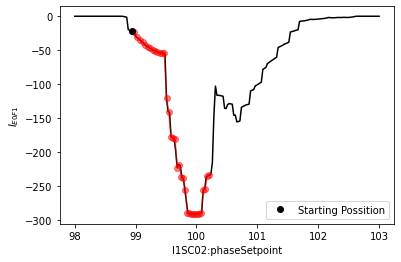

In [560]:
plt.plot(x_values, y_values, color='black', alpha= 1)

plt.plot(pathXModel, pathYModel, color='red', alpha= 0.5)
plt.plot(pathXModel, pathYModel, 'ro', alpha= 0.5)
plt.plot(setpoint, loss, 'o', color='black',label='Starting Possition')
plt.xlabel('I1SC02:phaseSetpoint')
plt.ylabel(r'$I_{E0F1}$')
plt.legend()
plt.savefig("I1SC02IModelPath", dpi=300, bbox_inches='tight')
plt.show()

## Path for Other optimizers

In [567]:
optimizer = ng.optimizers.NGOpt(parametrization=12, budget=30, num_workers=1)

mySecPos = sectionPos.copy()
myGloPos = globalPos.copy()
myLoss = loss

pathXNGOpt = []
pathYNGOpt = []
minPathYNGOpt = []

bestValue = myLoss

x = convertForOpimizer(mySecPos)
optimizer.tell(x, sim.get(globalPos))
    
for _ in range(optimizer.budget):
        
    x = optimizer.ask()
        
    myGloPos, mySecPos = updatePosition(x.args[0], allowedPVs, myGloPos)
    pathXNGOpt.append(mySecPos[11])
        
    myLoss = sim.get(myGloPos)
    optimizer.tell(x, myLoss)
    pathYNGOpt.append(myLoss)
        
    if myLoss < bestValue:
        bestValue = myLoss
    minPathYNGOpt.append(bestValue)

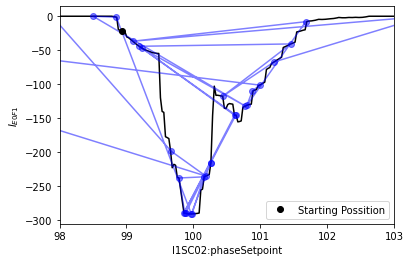

In [568]:
plt.plot(x_values, y_values, color='black', alpha= 1)

plt.plot(pathXNGOpt, pathYNGOpt, color='blue', alpha= 0.5)
plt.plot(pathXNGOpt, pathYNGOpt, 'bo', alpha= 0.5)
plt.xlabel('I1SC02:phaseSetpoint')
plt.ylabel(r'$I_{E0F1}$')
plt.xlim(98, 103)
plt.plot(setpoint, loss, 'o', color='black',label='Starting Possition')
plt.legend()
plt.savefig("I1SC02INGOptPath", dpi=300, bbox_inches='tight')
plt.show()

In [571]:
optimizer = ng.optimizers.OnePlusOne(parametrization=12, budget=30, num_workers=1)

mySecPos = sectionPos.copy()
myGloPos = globalPos.copy()
myLoss = loss

pathXNGOpt = []
pathYNGOpt = []
minPathYNGOpt = []

bestValue = myLoss

x = convertForOpimizer(mySecPos)
optimizer.tell(x, sim.get(globalPos))
    
for _ in range(optimizer.budget):
        
    x = optimizer.ask()
        
    myGloPos, mySecPos = updatePosition(x.args[0], allowedPVs, myGloPos)
    pathXNGOpt.append(mySecPos[11])
        
    myLoss = sim.get(myGloPos)
    optimizer.tell(x, myLoss)
    pathYNGOpt.append(myLoss)
        
    if myLoss < bestValue:
        bestValue = myLoss
    minPathYNGOpt.append(bestValue)

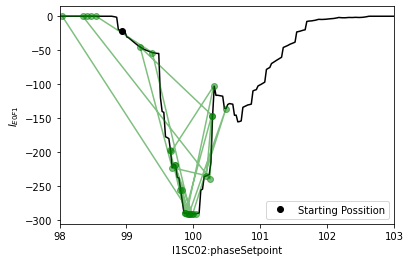

In [572]:
plt.plot(x_values, y_values, color='black', alpha= 1)

plt.plot(pathXNGOpt, pathYNGOpt, color='green', alpha= 0.5)
plt.plot(pathXNGOpt, pathYNGOpt, 'go', alpha= 0.5)
plt.xlabel('I1SC02:phaseSetpoint')
plt.ylabel(r'$I_{E0F1}$')
plt.xlim(98, 103)
plt.plot(setpoint, loss, 'o', color='black',label='Starting Possition')
plt.legend()
plt.savefig("I1SC02IOnePlusOnePath", dpi=300, bbox_inches='tight')
plt.show()

# Proposed Optimzer

In [537]:
loaded_model = tf.keras.models.load_model('ModelALLESpec.keras')
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, None, 32)             7424      
                                                                 
 lstm_1 (LSTM)               (1, None, 32)             8320      
                                                                 
 lstm_2 (LSTM)               (1, 32)                   8320      
                                                                 
 dense (Dense)               (1, 64)                   2112      
                                                                 
 dense_1 (Dense)             (1, 32)                   2080      
                                                                 
 dense_2 (Dense)             (1, 32)                   1056      
                                                                 
 dense_3 (Dense)             (1, 16)                   5

In [631]:
pathsOnePlusOne=[]
for i in range(100):
    optimizer = ng.optimizers.OnePlusOne(parametrization=12, budget=150, num_workers=1)
    _, _,pathY = performOtimization(optimizer, zeroStart = True)
    pathsOnePlusOne.append(pathY)

In [615]:
pathsNGOpt=[]
for i in range(100):
    optimizer = ng.optimizers.NGOpt(parametrization=12, budget=150, num_workers=1)
    _, _,pathY = performOtimization(optimizer, zeroStart = True)
    pathsNGOpt.append(pathY)

In [616]:
pathsModel=[]
for i in range(100):
    _, _,pathY = performOtimizationModelPlus(loaded_model, 150, zeroStart = True)
    pathsModel.append(pathY)

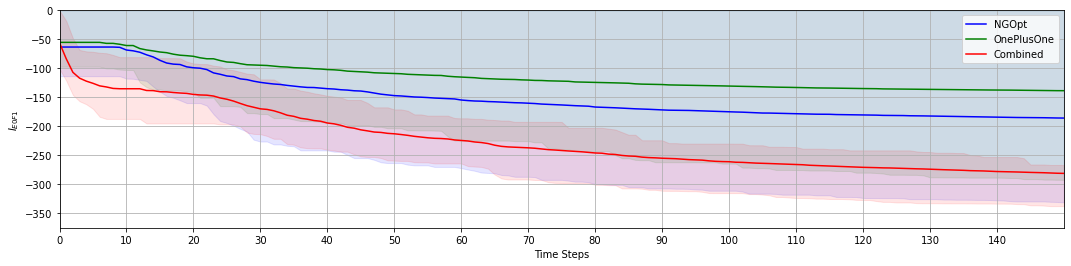

In [632]:
path_length = 151

paths1 = pathsNGOpt
paths2 = pathsOnePlusOne
paths3 = pathsRND
paths4 = pathsModel

# Calculate statistics
mean_path1 = np.mean(paths1, axis=0)
lower_percentile1 = np.percentile(paths1, 25, axis=0)
upper_percentile1 = np.percentile(paths1, 75, axis=0)

mean_path2 = np.mean(paths2, axis=0)
lower_percentile2 = np.percentile(paths2, 25, axis=0)
upper_percentile2 = np.percentile(paths2, 75, axis=0)

mean_path3 = np.mean(paths3, axis=0)
lower_percentile3 = np.percentile(paths3, 25, axis=0)
upper_percentile3 = np.percentile(paths3, 75, axis=0)

mean_path4 = np.mean(paths4, axis=0)
lower_percentile4 = np.percentile(paths4, 25, axis=0)
upper_percentile4 = np.percentile(paths4, 71, axis=0)

plt.figure().set_figwidth(6*3)


# Plot the mean path for each subplot
plt.plot(mean_path1, label='NGOpt', color='blue')
plt.plot(mean_path2, label='OnePlusOne', color='green')
#plt.plot(mean_path3, label='RandomSearch', color='yellow')
plt.plot(mean_path4, label='Combined', color='red')

# Plot the lower and upper percentiles as a shaded region for each subplot
plt.fill_between(range(path_length), lower_percentile1, upper_percentile1, color='blue', alpha=0.1)
plt.fill_between(range(path_length), lower_percentile2, upper_percentile2, color='green', alpha=0.1)
plt.fill_between(range(path_length), lower_percentile4, upper_percentile4, color='red', alpha=0.1)

plt.xlabel('Time Steps')
plt.ylabel(r'$I_{E0F1}$')
# Add legends
plt.legend()

plt.grid(True)
plt.xticks(np.arange(0, 150, 10))
plt.xlim((0,150))
plt.ylim((-375,0))
plt.savefig("ProposalvsSteps", dpi=300, bbox_inches='tight')
plt.show()